In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from torch.utils.data import Dataset, DataLoader
import time
import sys
import pandas as pd
import tensorflow as tf

https://www.researchgate.net/publication/347462953_Interpretable_and_effective_hashing_via_Bernoulli_variational_auto-encoders

In [2]:

# Device
CUDA_DEVICE_NUM = 0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cuda:0


In [3]:
train_dataset=np.genfromtxt('../input/mnist-in-csv/mnist_train.csv',delimiter=',')


In [4]:
train_dataset2=train_dataset
train_dataset2=train_dataset2[1:5000,1:]
train_dataset2=np.where(train_dataset2>0.5,1,train_dataset2)
train_dataset2=np.where(train_dataset2<0.5,0,train_dataset2)
train_dataset2=torch.from_numpy(train_dataset2)



In [5]:
test_dataset=train_dataset[5000:,1:]
test_dataset=np.where(test_dataset>0.5,1,test_dataset)
test_dataset=np.where(test_dataset<0.5,0,test_dataset)
test_dataset=torch.from_numpy(test_dataset)

In [6]:
test_dataset.shape

torch.Size([55001, 784])

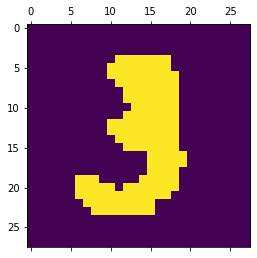

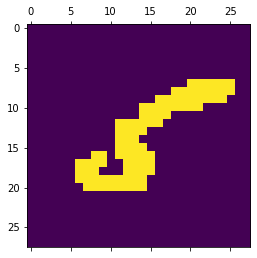

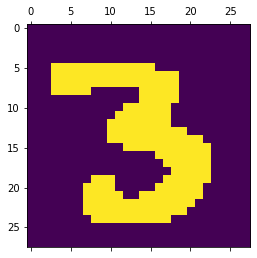

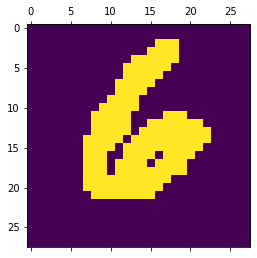

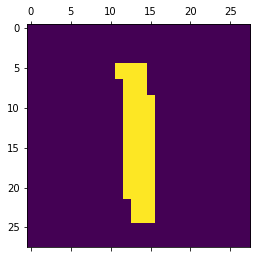

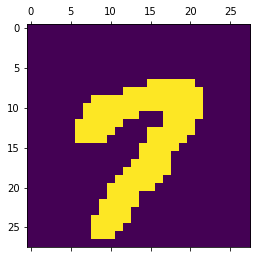

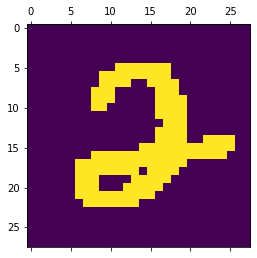

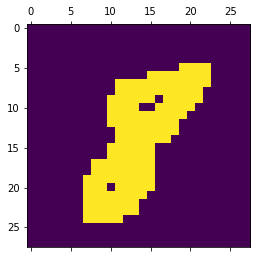

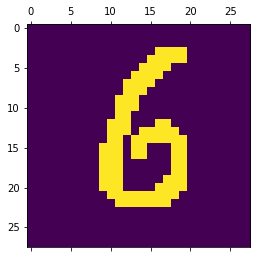

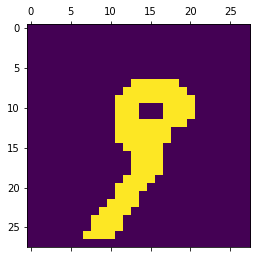

In [7]:
for i in train_dataset2[10:20]:
    plt.matshow(np.reshape(i.cpu().detach().numpy(),(28,28)))

In [8]:
##FOR IMPLEMENTING STRAIGHT THROUGH BVAE

class binarization(torch.autograd.Function):
    
    @staticmethod
    def forward(self,input):
        a=input.clone()
        a[a>0.5]=torch.tensor([1-(1e-5)])
        a[a<0.5]=torch.tensor([0+1e-5])
        return a

        
    @staticmethod
    def backward(self,grad_output):
        grad_input = grad_output.clone()
        return grad_input
        
        
        

In [9]:
class bVAE(nn.Module):
  def __init__(self,latent_dim):
    super(bVAE, self).__init__()
    
    self.encoder=nn.Sequential(
        nn.Linear(input_size,500),
        nn.LeakyReLU(0.1),
        nn.Dropout(p=0.3),

        nn.Linear(500,256),
        nn.LeakyReLU(0.1),
        nn.Dropout(p=0.3),

        nn.Linear(256,latent_dim),
        nn.Sigmoid(),
    )

    self.decoder=nn.Sequential(
        nn.Linear(latent_dim,256),
        nn.LeakyReLU(0.1),
        nn.Dropout(p=0.3),

        nn.Linear(256,500),
        nn.LeakyReLU(0.1),
        nn.Dropout(p=0.3),

        nn.Linear(500,input_size),
        nn.Sigmoid(),
        #nn.Dropout(p=0.3)
    )

  def encode(self,x):
    a= self.encoder(x)
    a=torch.clamp(a,min=1e-5,max=1-1e-5)
    return a

  def gumbel_reparam(self,a,lambd): # takes in the input from the encoder
    lambd=lambd.to(DEVICE)
    a=torch.clamp(a,min=1e-5,max=1-1e-5).to(DEVICE)
    u=torch.clamp(torch.rand(a.size()),min=1e-5,max=1-1e-5).to(DEVICE)
    x=((torch.log(a/(1-a))+torch.log(u/(1-u)))/lambd).to(DEVICE)
    x=torch.sigmoid(x)
    x=torch.clamp(x,min=1e-5,max=1-1e-5)
    return x



  def decode(self,x):
    d=self.decoder(x)
    return d


  def forward(self,x):
    e=self.encode(x)
    g=2*self.gumbel_reparam(e,lambd)-1
    b=binarization.apply(g)
    d=self.decode(g)
    return d,b,g,e

In [10]:
#u=torch.clamp(torch.rand(3),min=1e-5,max=1-1e-5).to(DEVICE)
#u

In [11]:
#model=torch.load('../input/modeld/model')

Everytime you call load a pretrained model, want to continue training, make surre that the lambda vallue is where you left it at

In [12]:
input_size=784
latent_dim=500
LEARNING_RATE=1e-3

num_epochs=2000

lambd=torch.Tensor([5.0])
lambd_min=torch.Tensor([0.45])
lambd_learning_rate=torch.Tensor([3e-4])


model=bVAE(latent_dim)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

In [ ]:
#model.load_state_dict(torch.load('../input/hello1/bVAE_state_dict_batch6'))

In [13]:
beta=0

In [14]:
def compute_loss(model,x):
    x_hat,bi,gumbell,a=model(x+torch.rand(x.size()).to(DEVICE))
    reconstruction_loss=torch.mean(torch.square(x-x_hat))
    #reconstruction_loss=F.mse_loss(x,x_hat)
    #loss=nn.BCELoss()
    
    #reconstruction_loss=loss(x_hat,x)
    KL_loss=torch.mean(latent_dim*np.log(2) + torch.sum(a*torch.log(a)+(1-a)*torch.log(1-a)))
    total_loss=reconstruction_loss+beta*KL_loss
    return total_loss,reconstruction_loss,KL_loss

def compute_loss2(model,x): ### WRONG!!!! CHECK THE AXIS OF KL_LOSS...should be 1
    x_hat,bi,gumbell,a=model(x)
    reconstruction_loss=torch.mean(torch.square(x-x_hat))
    #reconstruction_loss=torch.mean(F.mse_loss(x,x_hat))
    KL_loss=torch.mean(latent_dim*np.log(2) + torch.sum(a*torch.log(a)+(1-a)*torch.log(1-a),axis=0))
    total_loss=reconstruction_loss+beta*KL_loss
    return total_loss,reconstruction_loss,KL_loss


def compute_loss_batch(model,x, beta=beta):
#!!!!!!!!!#### befor runing check x and x1 always
    x=x.float()
    x1=torch.clamp(x+torch.normal(0.0,std,x.size()).to(DEVICE),0,1)
    x_hat,bi,gumbell,a=model(x1*torch.bernoulli(torch.ones(x.size()).to(DEVICE)*b))
    reconstruction_loss=torch.mean(torch.square(x-x_hat),axis=1) ## next instead of sum, make it mean!!!!!!!!
    #reconstruction_loss= F.binary_cross_entropy(x_hat, x)
    '''
    x_hat=torch.clamp(x_hat,min=1e-3,max=1-1e-3)
    reconstruction_loss=-(x*torch.log(x_hat)+(1-x)*torch.log(1-x_hat))
    reconstruction_loss=torch.mean(reconstruction_loss,axis=1)
    '''
    

    KL_loss=latent_dim*np.log(2) + torch.sum(a*torch.log(a)+(1-a)*torch.log(1-a),axis=1)

    total_loss=torch.mean(reconstruction_loss+beta*KL_loss)
    return total_loss,torch.mean(reconstruction_loss),torch.mean(KL_loss)




In [ ]:
#tl,rl,kl=compute_loss_batch(model,train_dataset2.float())


In [ ]:
#tl.shape

In [ ]:
# x_hat,bi,gumbell,a=model(train_dataset2.float())

In [ ]:
#a.size()

In [ ]:
#torch.mean(torch.sum(a*torch.log(a)+(1-a)*torch.log(1-a),axis=1)+latent_dim*np.log(2) )

In [ ]:
#torch.mean((x_hat-train_dataset2.float()),axis=1).size()

In [ ]:
#compute_loss_batch(model,train_dataset2.float())

In [ ]:
t=[]
r=[]
k=[]
ll=[]

In [ ]:


model.train()

for i in range(100):
  for j in train_dataset2:
    start_time = time.time()
    optimizer.zero_grad()
    j=j.to(DEVICE)

    tl,rl,kl=compute_loss(model,j.float())

    t.append(tl)
    r.append(rl)
    k.append(kl)

    tl.backward()
    optimizer.step()
  print('Time for epoch {} is {} sec, Loss: {},{},{} '.format(i + 1, time.time()-start_time,tl,rl,kl))
  if (i%100):
    if lambd>lambd_min:
      lambd=lambd*np.exp(-lambd_learning_rate*i)
      ll.append(lambd)

In [ ]:
x=np.arange(len(t))
t=list(map(float, t))
plt.scatter(x,t)

In [ ]:
x=np.arange(len(r))
r=list(map(float, r))
plt.scatter(x,r)

In [ ]:
x=np.arange(len(k))
k=list(map(float,k))
plt.scatter(x,k)

In [ ]:
x=np.arange(len(ll))
ll=list(map(float, ll))
plt.scatter(x,ll)

In [15]:
t=[]
r=[]
k=[]
n=[]#net loss.....1*rl + 1*kl
ll=[]

In [16]:

#lambd=torch.Tensor([5.0])
beta_values = torch.Tensor([0,1e-7, 1e-6, 1e-5, 1e-4, 1e-3 ]) #for annealing
beta_index=0
beta=beta_values[0]

model.train()
train_dataset2=train_dataset2.to(DEVICE)

for i in range(20000):
    std=0#torch.rand() # ideally 0
    b=1#torch.rand()#ideally 1
    start_time = time.time()
    optimizer.zero_grad()
    

    tl,rl,kl=compute_loss_batch(model,train_dataset2, beta=1e-2*0.5)

    t.append(tl)
    r.append(rl)
    k.append(kl)
    n.append(kl+rl)

    tl.backward()
    optimizer.step()
    if (i%1000==0):
        print('Time for epoch {} is {} sec, Loss: TL={},NL={}, RL={},KL={} '.format(i + 1, time.time()-start_time,tl,rl+kl,rl,kl))
        beta=beta_values[beta_index]

        if beta_index == (len(beta_values)-1):
            beta_index = len(beta_values)-1
            
        else:
            beta_index = beta_index + 1
        
    if (i%200==0):
        if lambd>lambd_min:
            lambd=lambd*np.exp(-lambd_learning_rate*i)
            
    ll.append(lambd)

Time for epoch 1 is 1.0193960666656494 sec, Loss: TL=0.2514348328113556,NL=0.5837424397468567, RL=0.24976497888565063,KL=0.33397746086120605 
Time for epoch 1001 is 0.06337332725524902 sec, Loss: TL=0.07478564977645874,NL=1.6724750995635986, RL=0.06675706803798676,KL=1.6057180166244507 
Time for epoch 2001 is 0.062186479568481445 sec, Loss: TL=0.08014111965894699,NL=2.9971401691436768, RL=0.06548283994197845,KL=2.931657314300537 
Time for epoch 3001 is 0.06216287612915039 sec, Loss: TL=0.07694772630929947,NL=3.441467046737671, RL=0.06004059687256813,KL=3.3814263343811035 
Time for epoch 4001 is 0.0608830451965332 sec, Loss: TL=0.07555033266544342,NL=3.7521042823791504, RL=0.05707518756389618,KL=3.6950290203094482 
Time for epoch 5001 is 0.06334614753723145 sec, Loss: TL=0.07515906542539597,NL=3.8673877716064453, RL=0.056102633476257324,KL=3.8112850189208984 
Time for epoch 6001 is 0.06281256675720215 sec, Loss: TL=0.07491890341043472,NL=3.9081790447235107, RL=0.05565629154443741,KL=3.8

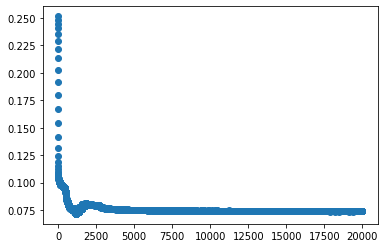

In [17]:
x=np.arange(len(t))
t=list(map(float, t))
plt.scatter(x,t)

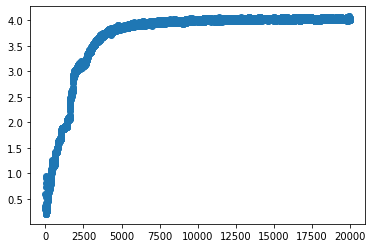

In [18]:
x=np.arange(len(n))
n=list(map(float, n))
plt.scatter(x,n)

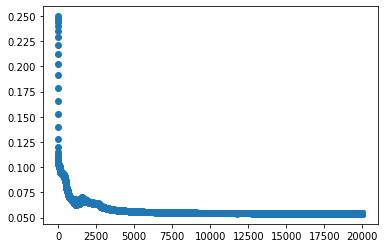

In [19]:
x=np.arange(len(r))
r=list(map(float, r))
plt.scatter(x,r)

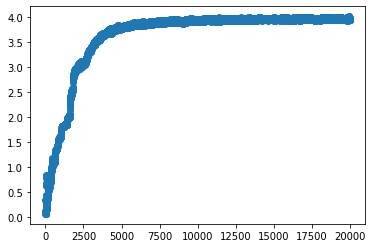

In [20]:
x=np.arange(len(k))
k=list(map(float, k))
plt.scatter(x,k)

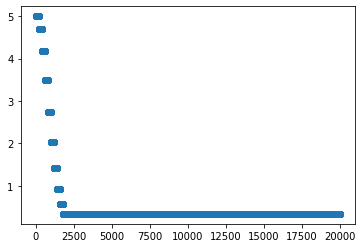

In [21]:
x=np.arange(len(ll))
ll=list(map(float, ll))
plt.scatter(x,ll)

In [22]:
model.eval()

bVAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=500, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.1)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=500, bias=True)
    (7): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=500, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=500, bias=True)
    (4): LeakyReLU(negative_slope=0.1)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=500, out_features=784, bias=True)
    (7): Sigmoid()
  )
)

In [ ]:
def latent_space_data(model, x):
    x=x.float()
    x_hat,bi,gumbel,a=model(x.to(DEVICE))
    return a#torch.mean(gumbel,axis=0)

def latent_space_data2(model, x):
    x=x.float()
    x_hat,bi,gumbel,a=model(x.to(DEVICE))
    pred = torch.argmax(gumbel, dim=1)
    one_hot=torch.zeros_like(gumbel).scatter_(1, pred.unsqueeze(1), 1.)
    return a#torch.sum(one_hot, axis=0)

In [ ]:
latent_space_train2 = latent_space_data(model,train_dataset2)
latent_space_train2=latent_space_train2.cpu().detach().numpy()
latent_space_train2= np.array(latent_space_train2)

latent_space_train2.shape

In [ ]:
plt.matshow(latent_space_train2[:10])

In [ ]:
xxx=np.linspace(1,latent_dim, latent_dim)
plt.bar(xxx, latent_space_train2[4] )
#plt.plot(latent_space_train[:10])
plt.show()

In [ ]:
latent_space_train2[1].shape

In [ ]:
latent_space_train = latent_space_data2(model,train_dataset2)
latent_space_train = latent_space_train.cpu().detach().numpy()
plt.matshow(latent_space_train[:5])
plt.colorbar()


In [ ]:
latent_space_test = latent_space_data(model,test_dataset)
latent_space_test = latent_space_test.cpu().detach().numpy()
plt.matshow(latent_space_test.reshape(10,5))
plt.colorbar()


In [ ]:
plt.matshow(latent_space_test.reshape(10,5)-latent_space_train.reshape(10,5))
plt.colorbar()

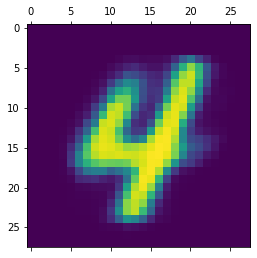

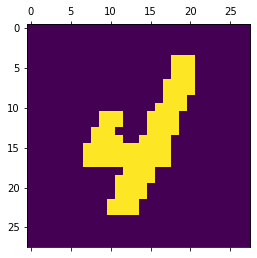

In [42]:
x=train_dataset2[np.random.randint(0,1000)]
#x=train_dataset2[55]
y=model(x.float().to(DEVICE))[0]
y=y.cpu().detach().numpy()
y=np.reshape(y,(28,28))
plt.matshow(y)

x1=x
x1=x1.cpu().detach().numpy()
plt.matshow(x1.reshape((28,28)))

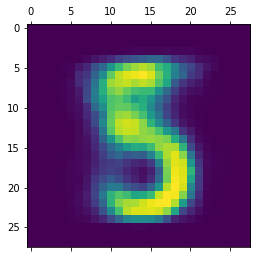

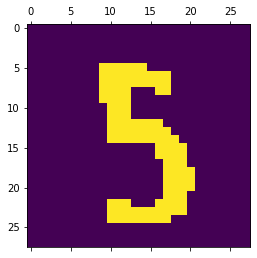

In [41]:
x=test_dataset[np.random.randint(0,2000)]
#x=test_dataset[5555]
y=model(x.float().to(DEVICE))[0]
y=y.cpu().detach().numpy()
y=np.reshape(y,(28,28))
plt.matshow(y)

x1=x
x1=x1.cpu().detach().numpy()
plt.matshow(x1.reshape((28,28)))

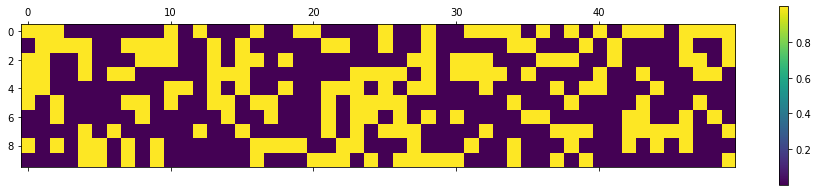

In [27]:
b=model(x.float().to(DEVICE))[1]
b=b.cpu().detach().numpy()
b=np.reshape(b,(10,50))
plt.matshow(b)
plt.colorbar()

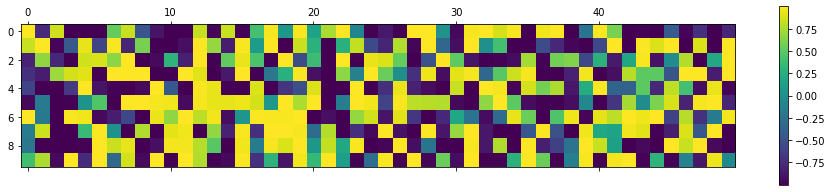

In [28]:
g=model(x.float().to(DEVICE))[2]
g=g.cpu().detach().numpy()
g=np.reshape(g,(10,50))
plt.matshow(g)
plt.colorbar()

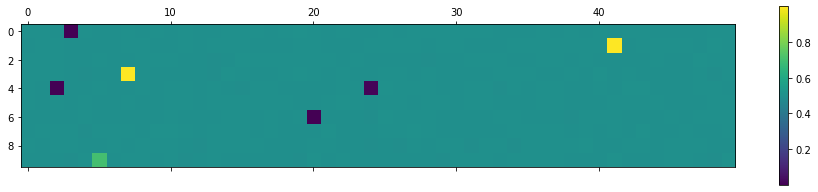

In [29]:
a=model(x.float().to(DEVICE))[3]
a=a.cpu().detach().numpy()
a=np.reshape(a,(10,50))
plt.matshow(a)
plt.colorbar()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == "":


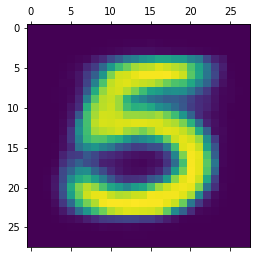

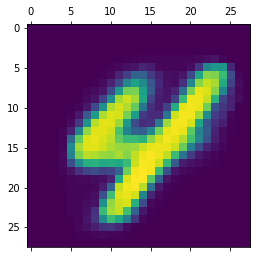

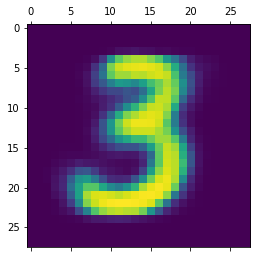

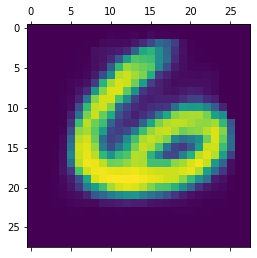

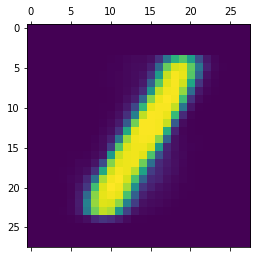

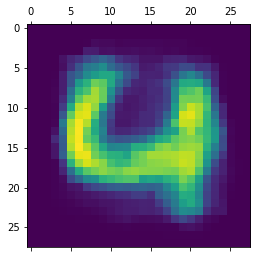

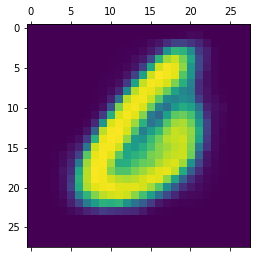

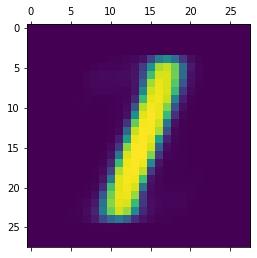

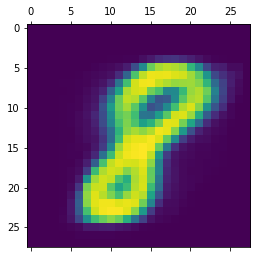

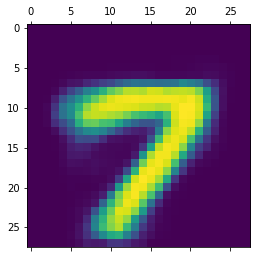

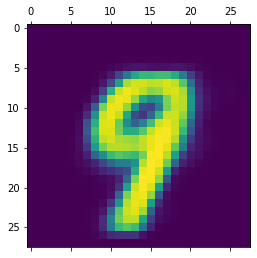

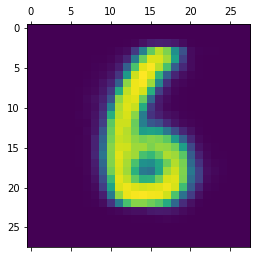

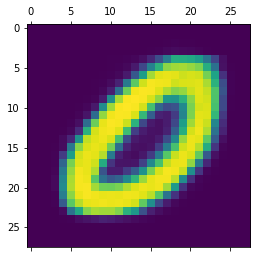

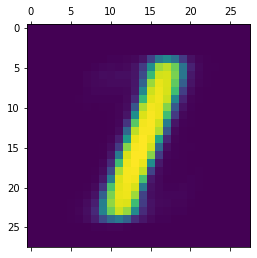

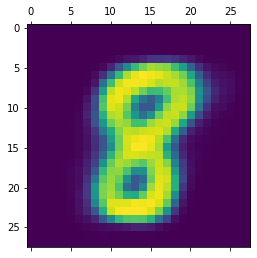

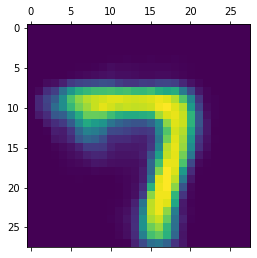

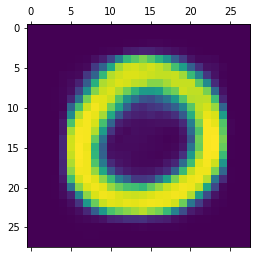

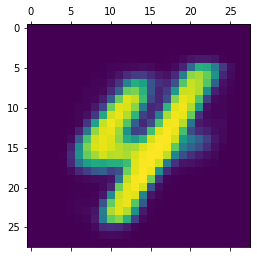

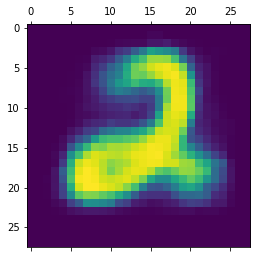

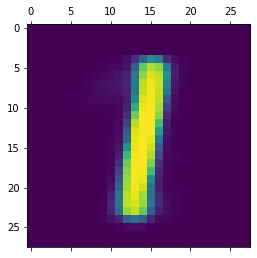

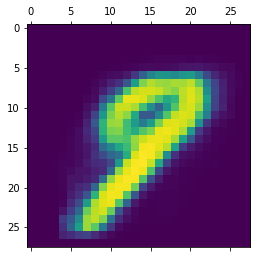

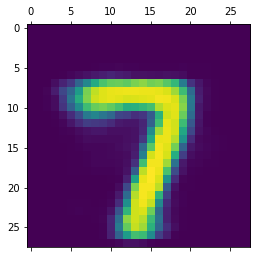

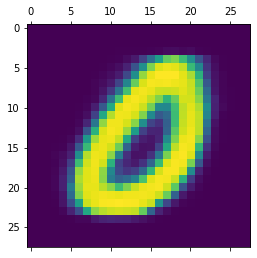

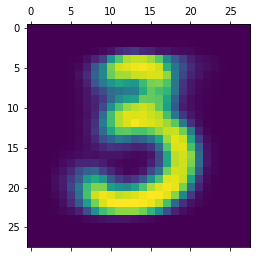

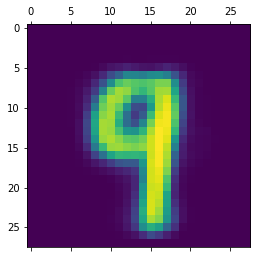

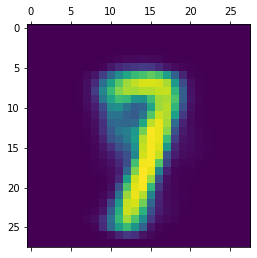

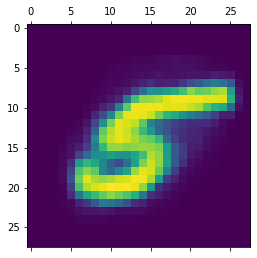

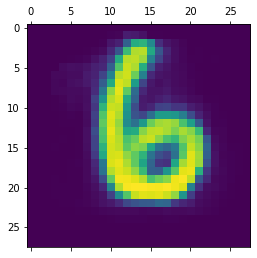

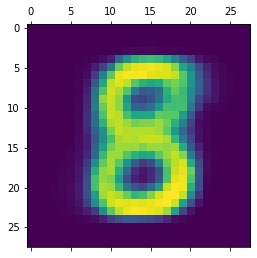

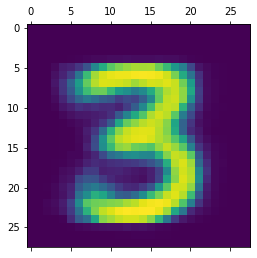

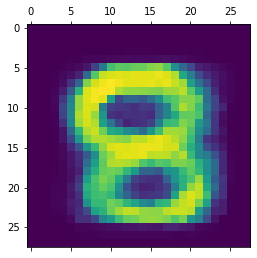

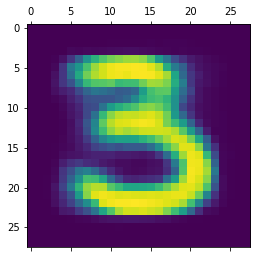

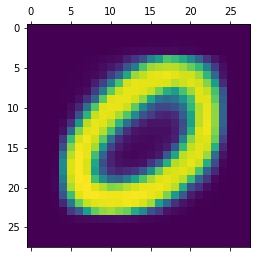

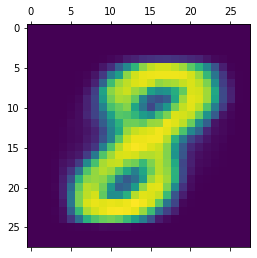

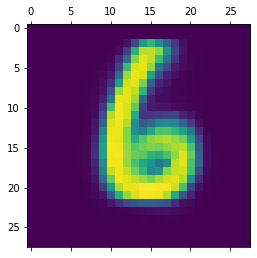

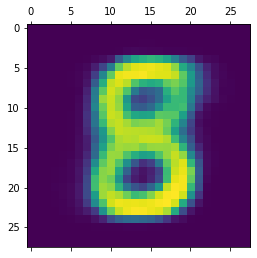

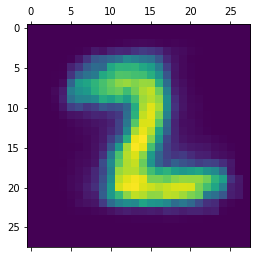

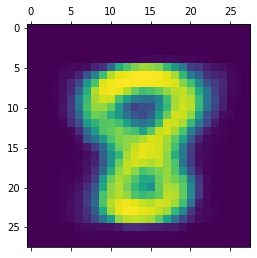

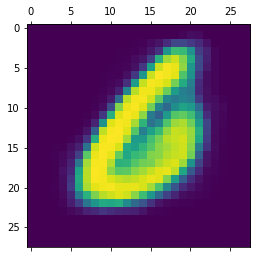

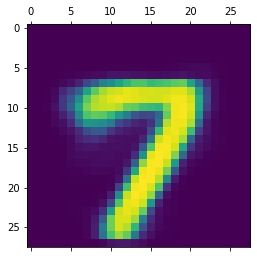

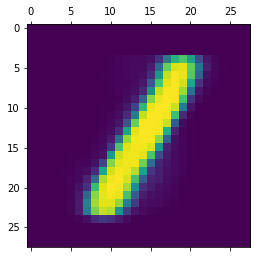

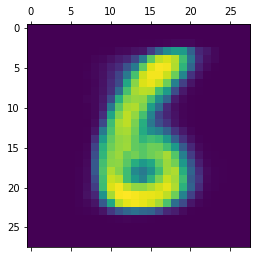

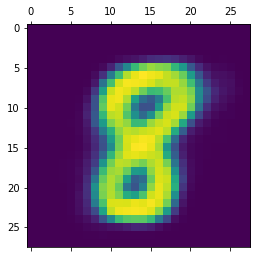

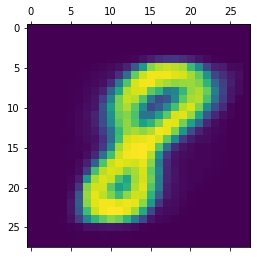

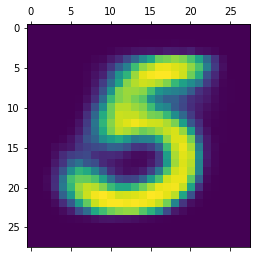

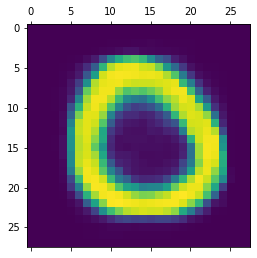

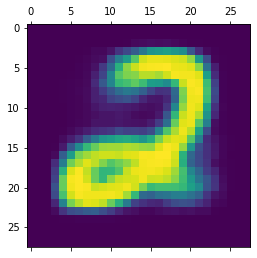

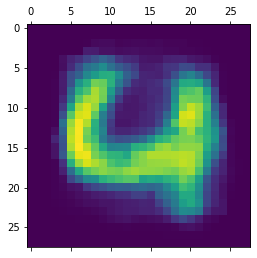

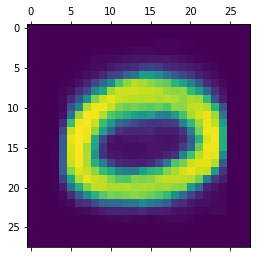

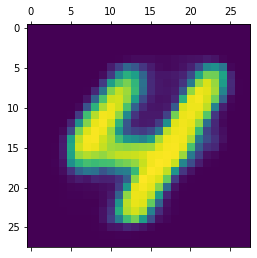

In [32]:
for i in range(50):
    a_check=torch.ones((latent_dim,))*0.5
    #a_check=torch.rand((latent_dim,))
    #decoder_input=model.gumbel_reparam(a_check,lambd)
    decoder_input=2*torch.bernoulli(a_check) .to(DEVICE)-1
    output=model.decode(decoder_input)
    
    output=output.cpu().detach().numpy()
    output=np.reshape(output,(28,28))
    #output[output>0.5]=1
    #output[output<0.5]=0
    plt.matshow(output)
    #plt.matshow(ski.morphology.area_closing(output,area_threshold=50))

In [ ]:
model(x.float().to(DEVICE))

In [ ]:
torch.save(model.state_dict(),'bVAE_state_dict_batch_final_v3')

In [ ]:
torch.save(model, 'model_batch_final_v3')